<font size="+3"><strong>Random Forest</strong></font>

In [4]:
import pickle
from scipy.io import arff

import matplotlib.pyplot as plt
import pandas as pd
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.pipeline import make_pipeline


In [14]:
def wrangle(filepath):
    data = arff.loadarff(filepath)
    df = pd.DataFrame(data[0])
    df["class"] = df["class"].str.decode("utf-8").astype(int)
    
    new_column_names = {f"Attr{i}": f"feat_{i}" for i in range(1, 65)}
    new_column_names["class"] = "bankrupt"

    df = df.rename(columns=new_column_names)
    return df

In [15]:
df = wrangle("/workspaces/codespaces-jupyter/data/1year.arff")
print(df.shape)
df.head()

(7027, 65)


,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,...,feat_56,feat_57,feat_58,feat_59,feat_60,feat_61,feat_62,feat_63,feat_64,bankrupt
0,0.200550,0.37951,0.39641,2.0472,32.3510,0.38825,0.249760,1.33050,1.1389,0.50494,...,0.121960,0.39718,0.87804,0.001924,8.4160,5.1372,82.658,4.4158,7.4277,0
1,0.209120,0.49988,0.47225,1.9447,14.7860,0.00000,0.258340,0.99601,1.6996,0.49788,...,0.121300,0.42002,0.85300,0.000000,4.1486,3.2732,107.350,3.4000,60.9870,0
2,0.248660,0.69592,0.26713,1.5548,-1.1523,0.00000,0.309060,0.43695,1.3090,0.30408,...,0.241140,0.81774,0.76599,0.694840,4.9909,3.9510,134.270,2.7185,5.2078,0
3,0.081483,0.30734,0.45879,2.4928,51.9520,0.14988,0.092704,1.86610,1.0571,0.57353,...,0.054015,0.14207,0.94598,0.000000,4.5746,3.6147,86.435,4.2228,5.5497,0
4,0.187320,0.61323,0.22960,1.4063,-7.3128,0.18732,0.187320,0.63070,1.1559,0.38677,...,0.134850,0.48431,0.86515,0.124440,6.3985,4.3158,127.210,2.8692,7.8980,0


# Split

In [17]:
target = "bankrupt"
X = df.drop(columns=target)
y = df[target]

print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (7027, 64)
y shape: (7027,)


In [19]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (5621, 64)
y_train shape: (5621,)
X_test shape: (1406, 64)
y_test shape: (1406,)


### Resample

In [20]:
over_sampler = RandomOverSampler(random_state=42)
X_train_over, y_train_over = over_sampler.fit_resample(X_train,y_train)
print("X_train_over shape:", X_train_over.shape)
X_train_over.head()

X_train_over shape: (10802, 64)


,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,...,feat_55,feat_56,feat_57,feat_58,feat_59,feat_60,feat_61,feat_62,feat_63,feat_64
0,0.535540,0.052232,0.441390,10.49400,165.210000,0.000000,0.535540,18.14500,1.81560,0.94777,...,27537.0,0.536310,0.565050,0.48781,0.000000,25.4630,4.6517,9.3465,39.0520,3.5452
1,0.000681,0.486750,-0.017475,0.94759,-5.587200,0.032626,0.000681,0.45175,0.99660,0.21989,...,-262.9,-0.003411,0.003096,1.00340,0.697370,106.4600,13.3880,35.6920,10.2260,4.9842
2,0.081678,0.422160,0.456520,2.70710,-0.063859,0.000000,0.101790,1.36880,1.97560,0.57784,...,2266.8,0.044539,0.141350,0.94900,0.000000,4.3322,9.3488,49.4080,7.3874,7.1565
3,0.172720,0.159200,0.627720,5.13760,16.825000,0.000000,0.172720,5.28150,1.93310,0.84080,...,1421.6,0.097010,0.205430,0.91067,0.008902,3.5406,9.2799,28.6460,12.7420,8.7645
4,0.070920,0.826400,-0.091116,0.71330,-85.703000,0.000000,0.070920,0.21007,0.79853,0.17360,...,-3796.8,0.102350,0.408520,0.91186,1.896600,11.1470,6.0414,145.2700,2.5126,1.0326


# Build Model

### Baseline

In [21]:
acc_baseline = y_train.value_counts(normalize=True).max()
print("Baseline Accuracy:", round(acc_baseline, 4))

Baseline Accuracy: 0.9609


### iterate

In [22]:
clf = make_pipeline(SimpleImputer(),RandomForestClassifier(random_state=42))
print(clf)

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=42))])


In [23]:
cv_acc_scores = cross_val_score(clf, X_train_over,y_train_over,cv = 5, n_jobs= -1)
print(cv_acc_scores)

[0.9990745  0.99814901 0.99861111 0.99814815 0.99861111]


In [24]:
params = {
    "simpleimputer__strategy" : ["mean","median"],
    "randomforestclassifier__n_estimators" : range(25,100,25),
    "randomforestclassifier__max_depth" : range(10,50,10)
}
params

{'simpleimputer__strategy': ['mean', 'median'],
 'randomforestclassifier__n_estimators': range(25, 100, 25),
 'randomforestclassifier__max_depth': range(10, 50, 10)}

In [25]:
model = GridSearchCV(
    clf,
    param_grid = params,
    cv = 5,
    n_jobs= -1,
    verbose = 1
)
model

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer', SimpleImputer()),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__max_depth': range(10, 50, 10),
                         'randomforestclassifier__n_estimators': range(25, 100, 25),
                         'simpleimputer__strategy': ['mean', 'median']},
             verbose=1)

In [26]:
model.fit(X_train_over,y_train_over)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer', SimpleImputer()),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__max_depth': range(10, 50, 10),
                         'randomforestclassifier__n_estimators': range(25, 100, 25),
                         'simpleimputer__strategy': ['mean', 'median']},
             verbose=1)

In [27]:
cv_results = pd.DataFrame(model.cv_results_)
cv_results.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_randomforestclassifier__max_depth,param_randomforestclassifier__n_estimators,param_simpleimputer__strategy,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.980578,0.036874,0.015500,0.001055,10,25,mean,"{'randomforestclassifier__max_depth': 10, 'ran...",0.990282,0.993984,0.992130,0.987963,0.990278,0.990927,0.002021,23
1,1.064304,0.053751,0.014889,0.000107,10,25,median,"{'randomforestclassifier__max_depth': 10, 'ran...",0.987506,0.993522,0.990741,0.989815,0.990278,0.990372,0.001928,24
2,1.920751,0.050577,0.024650,0.000492,10,50,mean,"{'randomforestclassifier__max_depth': 10, 'ran...",0.992133,0.995373,0.990741,0.992130,0.992593,0.992594,0.001522,19
3,1.991131,0.037705,0.024999,0.001032,10,50,median,"{'randomforestclassifier__max_depth': 10, 'ran...",0.988894,0.995373,0.992130,0.992593,0.992130,0.992224,0.002057,21
4,2.924310,0.095064,0.064680,0.033639,10,75,mean,"{'randomforestclassifier__max_depth': 10, 'ran...",0.992133,0.994910,0.989815,0.991204,0.993056,0.992223,0.001718,22
5,3.060740,0.085353,0.035806,0.004709,10,75,median,"{'randomforestclassifier__max_depth': 10, 'ran...",0.989820,0.994447,0.992593,0.993056,0.992593,0.992501,0.001503,20
6,1.056193,0.022069,0.015711,0.000206,20,25,mean,"{'randomforestclassifier__max_depth': 20, 'ran...",0.998612,0.997686,0.997685,0.997685,0.997222,0.997778,0.000454,14
7,1.134129,0.029083,0.015793,0.000336,20,25,median,"{'randomforestclassifier__max_depth': 20, 'ran...",0.996298,0.998149,0.997685,0.997685,0.997222,0.997408,0.000628,17
8,2.036437,0.013407,0.029841,0.005805,20,50,mean,"{'randomforestclassifier__max_depth': 20, 'ran...",0.999075,0.998149,0.998611,0.997685,0.997685,0.998241,0.000540,5
9,2.193851,0.069953,0.026898,0.001198,20,50,median,"{'randomforestclassifier__max_depth': 20, 'ran...",0.996761,0.998149,0.997685,0.997222,0.997685,0.997500,0.000472,16


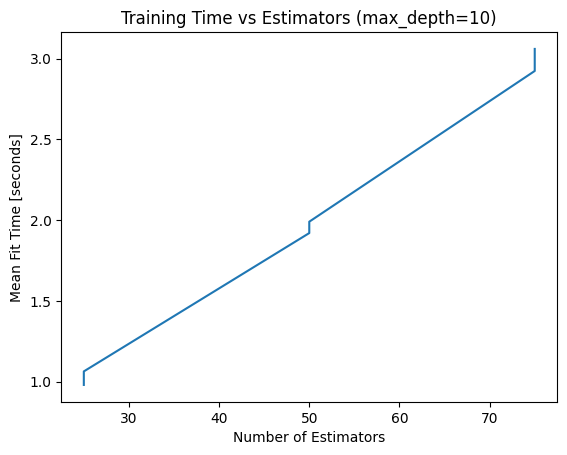

In [29]:
mask = cv_results["param_randomforestclassifier__max_depth"] ==10
plt.plot(cv_results[mask]["param_randomforestclassifier__n_estimators"],
        cv_results[mask]["mean_fit_time"]
        )
# Plot fit time vs n_estimators

# Label axes
plt.xlabel("Number of Estimators")
plt.ylabel("Mean Fit Time [seconds]")
plt.title("Training Time vs Estimators (max_depth=10)");

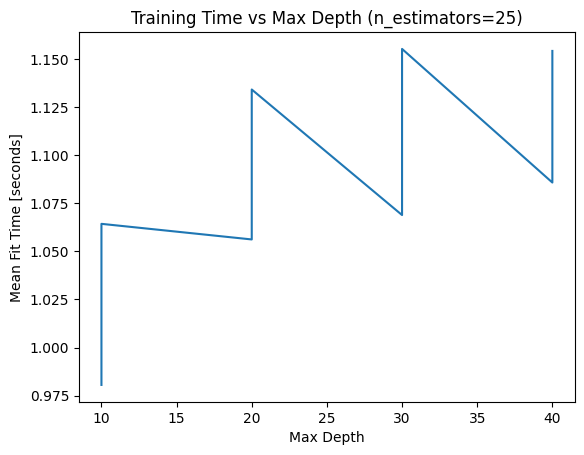

In [30]:
mask = cv_results["param_randomforestclassifier__n_estimators"] == 25
# Plot fit time vs max_depth
plt.plot(cv_results[mask]["param_randomforestclassifier__max_depth"],
        cv_results[mask]["mean_fit_time"]
        )
# Label axes
plt.xlabel("Max Depth")
plt.ylabel("Mean Fit Time [seconds]")
plt.title("Training Time vs Max Depth (n_estimators=25)");

In [31]:
cv_results[mask][["mean_fit_time","param_randomforestclassifier__max_depth","param_simpleimputer__strategy"]]

,mean_fit_time,param_randomforestclassifier__max_depth,param_simpleimputer__strategy
0,0.980578,10,mean
1,1.064304,10,median
6,1.056193,20,mean
7,1.134129,20,median
12,1.068871,30,mean
13,1.155226,30,median
18,1.085774,40,mean
19,1.154182,40,median


In [32]:
print(model.best_params_,model.best_score_,model.best_estimator_)

{'randomforestclassifier__max_depth': 30, 'randomforestclassifier__n_estimators': 75, 'simpleimputer__strategy': 'mean'} 0.9985187756011449 Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=30, n_estimators=75,
                                        random_state=42))])


In [33]:
acc_train = model.score(X_train,y_train)
acc_test = model.score(X_test,y_test)

print("Training Accuracy:", round(acc_train, 4))
print("Test Accuracy:", round(acc_test, 4))

Training Accuracy: 1.0
Test Accuracy: 0.9801


In [34]:
y_test.value_counts()

0    1355
1      51
Name: bankrupt, dtype: int64

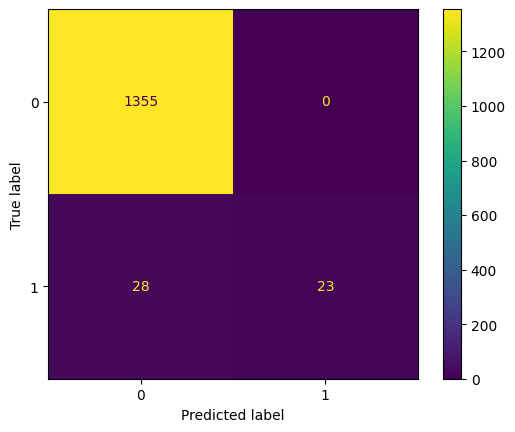

In [35]:
ConfusionMatrixDisplay.from_estimator(model,X_test,y_test);

## Communicate

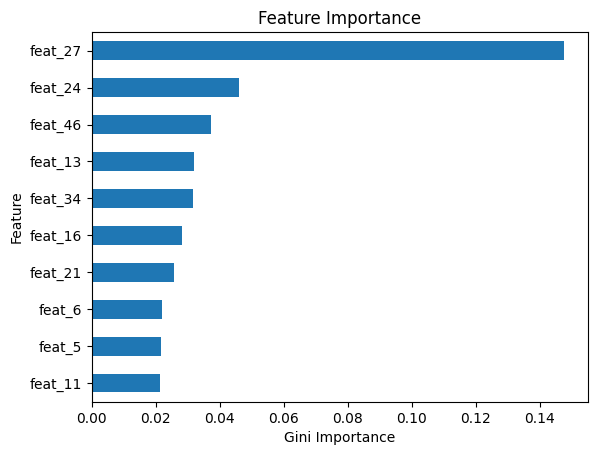

In [36]:
# Get feature names from training data
features = X_train.columns
# Extract importances from model
importances = model.best_estimator_.named_steps["randomforestclassifier"].feature_importances_
# Create a series with feature names and importances
feat_imp = pd.Series(importances,index=features).sort_values()
# Plot 10 most important features
feat_imp.tail(10).plot(kind="barh")
plt.xlabel("Gini Importance")
plt.ylabel("Feature")
plt.title("Feature Importance");

In [37]:
# Save model
with open("random_forest_model.pkl","wb") as file:
    pickle.dump(model,file)